# Welcome to the ATD Traffic Challenge!

For the dataset provided, your challenge is to create a model to find anomalous observations in sparsely sampled traffic flow observations. Here's how we define an anomaly for the challenge:

**Definition of anomaly:**

For a given sensor, fit a linear trend model to its hourly flow over time. Subtract this trend from the flow, and re-add the original flow's mean. Denote this detrended flow as $d$.

For a given sensor $s$, hour $h$, and weekday $w$, the ${n}^{th}$ observation of the detrended total flow $d_{shw}^{(n)}$ is anomalous if,

$$\left|d_{shw}^{(n)} - \mu_{shw} \right| \geq 3\sigma_{shw}$$


where $\mu_{shw}$ and $\sigma_{shw}$ are the detrended flow sample mean and standard deviation, respectively.

**Data source:**

The hourly traffic flow data was obtained from the California Department of Transformation; you can download raw data and read the user's manual once you've made an account at the [Caltrans Pems website](http://pems.dot.ca.gov/).

**What to expect in this Notebook...:**

In this Notebook, we'll walk through how to detect anomalous observations in the complete, ground truthed City 1 dataset. Because the the anomalies are already marked in this data set, we can analyze the performance of our algorithm when we apply a baseline detector to find anomalies in sparse samples of the data. We'll read in and view the data, detrend the traffic flow values to make the data stationary, and detect anomalies using a baseline detector. Finally, we'll compute the precision, recall, and $F_{1}$ scores to analyze the quality of our predictions.

**References:**

* For documentation on the precision, recall, and $F_{1}$ scores calculated below, please refer to the [scikit learn documentation](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics) on metrics and scoring.
* For an overview of the Jupyter Notebook Interface, please refer to the [user documentation](https://jupyter-notebook.readthedocs.io/en/stable/notebook.html#notebook-user-interface).

In [1]:
import itertools
from pathlib import Path

%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import atd2020

%load_ext nb_black

<IPython.core.display.Javascript object>

## Read in the data:

In [2]:
filename = Path("data/City1.parquet.brotli")
# filename = Path("data/City2_downsampled.parquet.brotli")

<IPython.core.display.Javascript object>

In [3]:
help(atd2020.utilities.read_data)

data = atd2020.utilities.read_data(filename)
data.head()

Help on function read_data in module atd2020.utilities:

read_data(filepath)
    Reads parquet or csv into a dataframe with "Timestamp" as datetime.
    
    Parameters
    ----------
    filepath : str or Pathlib.Path
        Path to .csv or .parquet file containing "Timestamp" column.
    
    Returns
    -------
    pandas.DataFrame



Timestamp  ID  TotalFlow  Year  Month  Day  Hour Weekday  \
0 2016-01-01 00:00:00   0     1058.0  2016      1    1     0  Friday   
1 2016-01-01 01:00:00   0      853.0  2016      1    1     1  Friday   
2 2016-01-01 02:00:00   0      631.0  2016      1    1     2  Friday   
3 2016-01-01 03:00:00   0      502.0  2016      1    1     3  Friday   
4 2016-01-01 04:00:00   0      353.0  2016      1    1     4  Friday   

   Latitude  Longitude  Anomaly  Fraction_Observed  Observed  
0  0.175793   0.167569     True               0.05     False  
1  0.175793   0.167569     True               0.05      True  
2  0.175793   0.167569    False               0.05     False  
3  0.175793   0.167569    False               0.05     False  
4  0.175793   0.167569    False               0.05     False

<IPython.core.display.Javascript object>

## Columns in Data:

- **Timestamp:** 
    - The date and time at the beginning of the 1 hour interval, format %m/%d/%Y %H:%M:%S.
    - datetime64.
- **ID:**
    - Unique station identifier. A station is a vehicle detection device implanted in the road which measures vehicle flow and occupancy data every 30 seconds every day all day. This data gets aggregated into 5-min and 1-hour aggregations. The IDs given in the dataset are not the original values; we have remapped the station IDs to make them ambiguous.
    - int64.
- **Observed:**
    - The percentage of data that is actually observed, as opposed to imputed, at the 5 min aggregate level.
    - int64.
- **TotalFlow:**
    - Sum of cars passing over the station in an hour (number of vehicles/hour).
    - float64.
- **Year:**
    - The four digit year the observation was taken, format YYYY.
    - int64.
- **Month:**
    - The month the observation was taken, format 1-12.
    - int64.
- **Day:**
    - The day the observation was taken, format 1-31.
    - int64.
- **Hour:**
    - The hour the observation was taken, format 0-23.
    - int64.
- **Weekday:**
    - The day of the week the observation was taken, format {"Monday", ..., "Sunday"}.
    - object.
- **Latitude:**
    - The normalized latitude of the sensor (values range from 0-1).
    - float64.
- **Longitude:**
    - The normalized longitude of the sensor (values range from 0-1).
    - float64.
- **Anomaly:**
    - Anomalies marked as True, otherwise False.
    - Included in the complete data set (City 1) only.
    - bool.
- **Fraction_Observed:**
    - If `Fraction_Observed=0.02`, that means that the data was randomly downsampled so that only 2% of the original data remains.
    - Example: If there were 100 observations in the original dataset for each sensor, and a particular sensor has `Fraction_Observed=0.1`, then that sensor would have 10 observations with `Observed=True` and the remaining 90 observations would have `Observed=False`.
    - This column can be helpful when measuring how detector performance varies with the amount of data available.
    - float64.
- **Observed:**
    - An observation is marked `True` if it was observed by a sensor, otherwise `False`.
    - Note: For City1, this column will be a mixture of `True` and `False` values. This is because all of the observations are included in this dataset regardless of whether they were downsampled.
    - Note: For City2, this column will contain only `True` values. This is because all observations with `Observed=False` have already been removed from the dataset.
    - bool.

There are 500 randomly chosen station IDs in the dataframe, each with an observation at every hour over a two-year time span, with no missing data.

## Viewing the data

By setting the index of our pandas.DataFrame to the `Timestamp` column, we are able to conveniently slice and graph the data. Here are some useful graphs for viewing the data. You can see more examples of slicing and viewing time series data [here](https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/).

Below, we plot the `TotalFlow` of all sensors in the dataset over time. So, there are 500 markers at every timestamp.

<IPython.core.display.Javascript object>


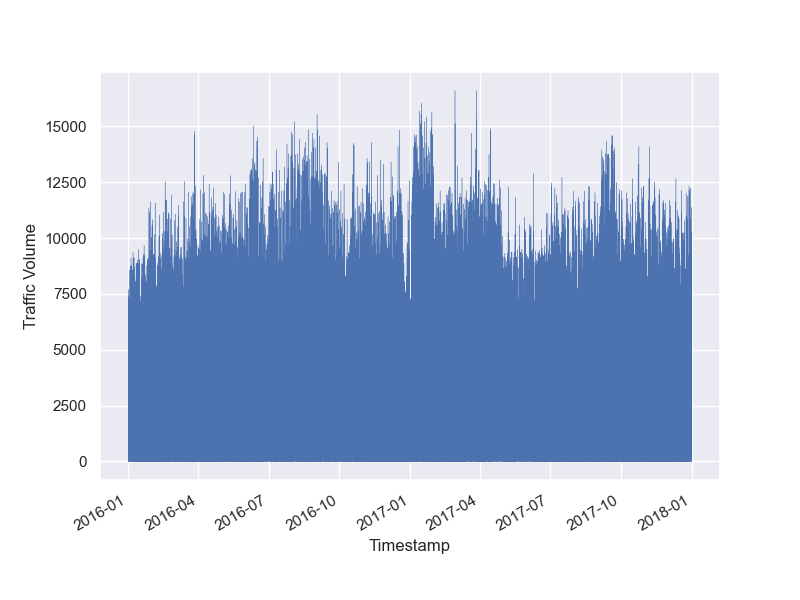

Text(0, 0.5, 'Traffic Volume')

<IPython.core.display.Javascript object>

In [5]:
# Set the index to Timestamp
data.set_index("Timestamp", drop=False, inplace=True)

# Use seaborn style defaults and set the default figure size
sns.set(rc={"figure.figsize": (8, 6)})

# Plot the total traffic Volume 'TotalFlow' for all sensors
_, ax = plt.subplots()
data["TotalFlow"].plot(linewidth=0.25, ax=ax)
ax.set_ylabel("Traffic Volume")

In the example below, we plot a small slice of the observations for the last few days in November 2016.

<IPython.core.display.Javascript object>


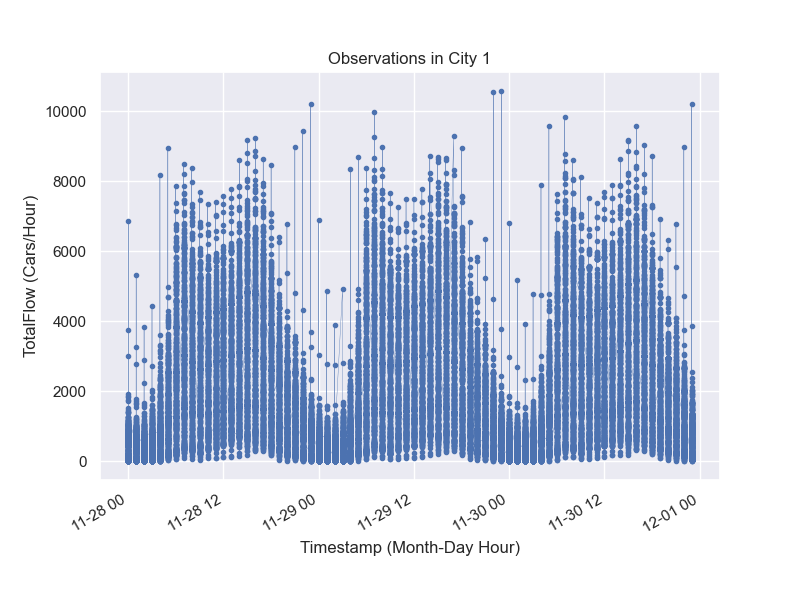

Text(0.5, 1.0, 'Observations in City 1')

<IPython.core.display.Javascript object>

In [5]:
_, ax = plt.subplots()
data["2016-11-28":"2016-11-30"]["TotalFlow"].plot(marker=".", linewidth=0.25, ax=ax)
ax.set_xlabel("Timestamp (Month-Day Hour)")
ax.set_ylabel("TotalFlow (Cars/Hour)")
ax.set_title("Observations in City 1")

## Grouping the dataframe:
You can also group the dataframe into a pandas GroupBy object. You can group by one or multiple columns, where each resulting group is a dataframe. Let's group by station ID, Weekday, and Hour and take a look at the data.

In [18]:
# Group the data, each group is a dataset
groups = data.groupby(["ID", "Weekday", "Hour"])
group_lst = list(groups.groups)
print(group_lst[:5])

[(0, 'Friday', 0), (0, 'Friday', 1), (0, 'Friday', 2), (0, 'Friday', 3), (0, 'Friday', 4)]


<IPython.core.display.Javascript object>

In [19]:
# Get a group by name
sensor_id = 250
weekday = "Monday"
hour = 0
group_name = (sensor_id, weekday, hour)
groups.get_group(group_name).head()

Timestamp   ID  TotalFlow  Year  Month  Day  Hour Weekday  Latitude  \
118368 2016-01-04  250       53.0  2016      1    4     0  Monday  0.122168   
118536 2016-01-11  250       38.0  2016      1   11     0  Monday  0.122168   
118704 2016-01-18  250       58.0  2016      1   18     0  Monday  0.122168   
118872 2016-01-25  250       58.0  2016      1   25     0  Monday  0.122168   
482664 2016-02-01  250       48.0  2016      2    1     0  Monday  0.122168   

        Longitude  Anomaly  Fraction_Observed  Observed  
118368   0.216018    False               0.01     False  
118536   0.216018    False               0.01     False  
118704   0.216018    False               0.01     False  
118872   0.216018    False               0.01     False  
482664   0.216018    False               0.01     False

<IPython.core.display.Javascript object>

## Plotting a group and identifying anomalies in the graph:

First, we'll calculate the stationary mean and standard deviation for each group. A stationary time series is one where the mean and variance are not time dependant. We also calculate the number of observations per group. Lastly, we'll define an anomaly as an observations that lies three standard deviations from the mean, so we'll calculate the upper and lower boundaries for each group as well.

(0, 'Monday', 1)
395.86538461538464 94.78284405949198 111.51685243690872 680.2139167938606


<IPython.core.display.Javascript object>


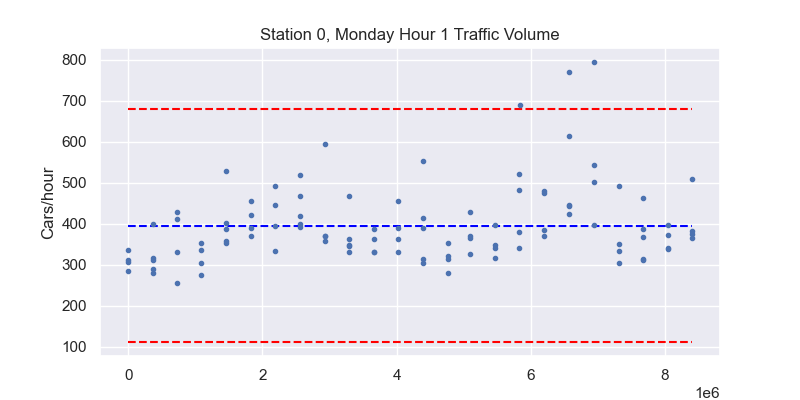

Text(0.5, 1.0, 'Station 0, Monday Hour 1 Traffic Volume')

<IPython.core.display.Javascript object>

In [23]:
# Define which group you would like to see. We chose the first group in the group_lst:
station_weekday_hour = group_lst[25]
print(station_weekday_hour)
group = groups.get_group(station_weekday_hour)

# Calculate the sample mean and sample standard deviation of TotalFlow for the group.
# In addition, since we define anomalous behavior as three standard deviations away
# from the mean, we can compute the upper and lower bounds that define anomalous
# behavior.
group_sample_mean = group["TotalFlow"].mean()
group_sample_std = group["TotalFlow"].std()
anomaly_lower_bound = group_sample_mean - 3 * group_sample_std
anomaly_upper_bound = group_sample_mean + 3 * group_sample_std
print(group_sample_mean, group_sample_std, anomaly_lower_bound, anomaly_upper_bound)

# For the chosen sensor plot the Traffic Flow (cars/hour) with the mean and anomaly
# thresholds overlaid.
sns.set(rc={"figure.figsize": (8, 4)})
_, ax = plt.subplots()
group["TotalFlow"].plot(marker=".", linestyle="none", ax=ax)
ax.hlines(
    [group_sample_mean, anomaly_lower_bound, anomaly_upper_bound],
    group.index.min(),
    group.index.max(),
    colors=["blue", "red", "red"],
    linestyle="dashed",
)

# Add labels
ax.set_ylabel("Cars/hour")
ax.set_title("Station {}, {} Hour {} Traffic Volume".format(*station_weekday_hour))

In the plot above, we have chosen one sensor. You can change the sensor being plotted in the first line of the cell block above. There are 500 sensors in the data, so you can replace the number in 'station = ID_list[0]' with any integer from 0-499.

The blue dots each represent an hourly aggregated TotalFlow reading at the chosen sensor on the chosen weekday and within the chosen hour. The observations lying outside the boundaries are anomolous.

# Prepare the data for anomaly detection

We need to do two things to prepare the data for anomaly detection:

1. Remove all observations with `Observed=False`
    - Since we have imported `City1`, the complete dataset, we need to downsample the data by removing any observations where `Observed=False` before we run the Baseline detector. Otherwise, we would be using data that was not actually observed by the sensor.
2. Detrend the data
    - Recall that we defined an observation to be anomalous if its `TotalFlow` is over three standard deviations away from the **detrended** mean `TotalFlow` for the observation's sensor ID, weekday, and hour.
    - The data was detrended prior to anomaly detection in order to account for linear growth trends. To illustrate how detrending the data will affect which observations will be labelled as anomalies, consider a toy example where a sensor observes exactly one more car each day than the last. In this case, the most extreme observations would be at the beginning and end of the time period. However, because we remove the linear trend, the detrended TotalFlow time series will be flattened into a series with a constant value, and no observations will be labelled as anomalous.

In [4]:
help(atd2020.detrend.detrend)

# Reset the index to observation number, since we previously set it to Timestamp when plotting in the above cells
data.reset_index(drop=True, inplace=True)

# If using full dataset, drop observations that were not "keep"
if "Observed" in data.columns:
    data = data.loc[data["Observed"]].copy()

# Detrend the data to make it stationary (constant mean and variance)
data_detrended = atd2020.detrend.detrend(data)

Help on function detrend in module atd2020.detrend:

detrend(df, inplace=False)
    Remove trend from TotalFlow.
    
    Parameters
    ----------
    df : pandas.DataFrame
        df containing columns=["ID", "Timestamp", TotalFlow"].
    
    inplace : bool, default=False
    
    Returns
    -------
    df : pandas.DataFrame or None
        Copy of df with detrended flow written to column "TotalFlow" and the original
        "TotalFlow" written to column "TotalFlow_original" or None if `inplace=True`.



<IPython.core.display.Javascript object>

# Detect anomalies using the baseline detector  

In [5]:
help(atd2020.detector.BaselineDetector)

# Returns a dataframe with predicted anomalies in the 'Anomaly' column
anomalies_baseline = atd2020.detector.BaselineDetector().fit_predict(data_detrended)
anomalies_baseline.head()

Help on class BaselineDetector in module atd2020.detector:

class BaselineDetector(builtins.object)
 |  BaselineDetector(groupby=('ID', 'Weekday', 'Hour'))
 |  
 |  Anomaly detector used for ground truthing and baseline comparison.
 |  
 |  Parameters
 |  ----------
 |  groupby : iterable, default=("ID", "Weekday", "Hour")
 |      List of column names by which observations are grouped.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, groupby=('ID', 'Weekday', 'Hour'))
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  fit(self, df, n_std=3)
 |      Fit anomaly thresholds for groups induced by self.groupby.
 |      
 |      Parameters
 |      ----------
 |      df : pandas.DataFrame
 |          A dataframe containing all fields in self.groupby, "Timestamp",
 |          and "TotalFlow".
 |      n_std: float, default=3
 |          Number of standard deviations outside which TotalFlow observations
 |          will be considered an anomaly.
 |      
 |    

Timestamp  ID  TotalFlow_original  Year  Month  Day  Hour Weekday  \
0 2016-01-01 01:00:00   0               853.0  2016      1    1     1  Friday   
1 2016-01-01 12:00:00   0              2731.0  2016      1    1    12  Friday   
2 2016-01-01 16:00:00   0              2740.0  2016      1    1    16  Friday   
3 2016-01-04 10:00:00   0              2567.0  2016      1    4    10  Monday   
4 2016-01-04 23:00:00   0               790.0  2016      1    4    23  Monday   

   Latitude  Longitude  Anomaly  Fraction_Observed  Observed    TotalFlow  \
0  0.175793   0.167569    False               0.05      True   850.648310   
1  0.175793   0.167569    False               0.05      True  2728.651222   
2  0.175793   0.167569    False               0.05      True  2737.652280   
3  0.175793   0.167569    False               0.05      True  2564.669750   
4  0.175793   0.167569    False               0.05      True   787.673191   

          mean         std  count  lower_thresh  upper_thresh  Fallback  
0   573.627501  125.702785      8    196.519144    950.735857     False  
1  3618.793129  352.831451      9   2560.298776   4677.287482     False  
2  3565.011020  513.147158     10   2025.569546   5104.452495     False  
3  2892.977002  151.807795      9   2437.553617   3348.400387     False  
4   784.217658    4.886861      2    769.557075    798.878241     False

<IPython.core.display.Javascript object>

# Write detections to CSV file
The output CSV file is in the format required for challenge submissions. You can find the output CSV in the `results/` directory.

In [8]:
help(atd2020.utilities.to_csv)

# Select 'Timestamp', 'ID', and 'Anomaly' columns and write our
# predictions dataframe to a CSV file in the results/ directory.
atd2020.utilities.to_csv(
    anomalies_baseline[["Timestamp", "ID", "Anomaly"]],
    (Path("results") / filename.stem).with_suffix(".csv"),
)

Help on function to_csv in module atd2020.utilities:

to_csv(df, filepath)
    Write dataframe to csv in format compatible with atd2020.metrics.
    
    Parameters
    ----------
    df : pandas.DataFrame
    
    filepath : str or Pathlib.Path



<IPython.core.display.Javascript object>

# Compute metrics

The `results/City1.csv` file contains our anomaly predictions on the downsampled data set and the 'Anomaly' column of `data/City1.parquet.brotli` contains the anomaly *truths*. We make use of [*scikit learn's* classification metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics) to calculate the *precision*, *recall*, $F_{1}$ *score*, and *accuracy* of our prediction as follows:


$$precision = \frac{tp}{tp + fp},$$

$$recall = \frac{tp}{tp + fn},$$

$$F_{1} = 2\cdot \frac{precision\cdot recall}{precision + recall},$$

$$accuracy = \frac{tp + tn}{tp + tn + fp + fn},$$

where $tp$, $fp$, $tn$, and $fn$ are defined as the number of true positives, false positives, true negatives, and false negatives, respectively. These metrics measure what fraction of our predicted anomalies were true anomalies (precision), what fraction of true anomalies did we correctly predict (recall), the harmonic mean of precision and recall ($F_{1}$ score), and the fraction of correct predictions (both positive and negative) out of all predictions made (accuracy). 

In the following cell, we compute the number of $tp$, $fp$, $tn$, and $fn$, as well as the precision, recall, $F_{1}$ score, and accuracy for each `Fraction_Observed` group and for the entire (*overall*) downsampled data set. Also included is the *support* for each group and for the overall data set, defined as the number of true anomalies

$$support = tp + fn.$$

In [6]:
help(atd2020.metrics.metrics)

assert (
    "Anomaly" in data_detrended.columns
), f"{filename.name} does not contain truth, so we can't compute metrics.\n\nThis is expected behavior for City2."

metrics_baseline = atd2020.metrics.metrics(
    data_detrended, anomalies_baseline, groupby="Fraction_Observed",
)
metrics_baseline

Help on function metrics in module atd2020.metrics:

metrics(df_true, df_pred, groupby=None, output_df=True, output_flat=False)
    Compute metrics and output as either dataframe or formatted string.
    
    This function computes the following metrics:
        - True Positive
        - False Positive
        - True Negative
        - False Negative
        - Precision (of anomalies)
        - Recall (of anomalies)
        - F1 (of anomalies)
        - Accuracy
        - Support
    
    By default, metrics are computed over the whole test set. These metrics
    are labelled as "overall" in the index.
    
    Optionally, metrics can be computed over subsets of the dataset using the
    groupby argument. When groupby is provided, we also compute metrics for
    all groups in _register(df_true, df_pred).groupby(groupby). These metrics
    will have the same index as their corresponding group name.
    
    Parameters
    ----------
    df_true : pandas.DataFrame
        Ground truth da

True Positive  False Positive  True Negative  \
Fraction_Observed                                                 
overall                     2580            1198         657670   
0.01                           0              15          17358   
0.02                           0              12          34649   
0.05                           1               1          86721   
0.1                          329             163         173096   
0.2                         2250            1007         345846   

                   False Negative  Precision    Recall        F1  Accuracy  \
Fraction_Observed                                                            
overall                      5452   0.682901  0.321215  0.436918  0.990028   
0.01                          227   0.000000  0.000000  0.000000  0.986250   
0.02                          439   0.000000  0.000000  0.000000  0.987151   
0.05                         1077   0.500000  0.000928  0.001852  0.987722   
0.1                          1912   0.668699  0.146809  0.240761  0.988177   
0.2                          1797   0.690820  0.555967  0.616101  0.992009   

                   Support  
Fraction_Observed           
overall               8032  
0.01                   227  
0.02                   439  
0.05                  1078  
0.1                   2241  
0.2                   4047

<IPython.core.display.Javascript object>

From this table we see that the detector's failed to detect any anomalies when `Fraction_Observed` was `0.01` or `0.02`. More generally, we see that detector performance improves as `Fraction_Observed` increases, taking on a maximum `F1` score of `0.6161` for `Fraction_Observed=0.2`.

# Plot the baseline detector's $F_{1}$ score vs. `Fraction_Observed` 

Help on function plot in module atd2020.metrics:

plot(df, metric='F1', numeric_x=False, **kwargs)
    Plot particular metric for all columns matching "metric@*".
    
    Parameters
    ----------
    df : pandas.DataFrame
        A flattened metrics dataframe.
    
    metric : str, default="F1"
        Metric to plot.
    
    numeric_x : bool, default=False
        If True, convert column name suffixes after @ (e.g., 0.1 in F1@0.1) to
        numeric prior to plotting. Note: this ignores "*@overall" columns.
        Otherwise, the line plot will treat suffixes as strings.
    
    **kwargs
        The remaining keyword arguments are passed to pandas.DataFrame.plot().
    
    Returns
    -------
    ax : matplotlib.axes.Axes
        For each row in the index, create a lineplot over all columns matching
        "metric@*" with the suffix of the column name (after the "@") as the
        x-axis and corresponding metric value on the y-axis. If numeric_x is
        True, we convert the

<IPython.core.display.Javascript object>


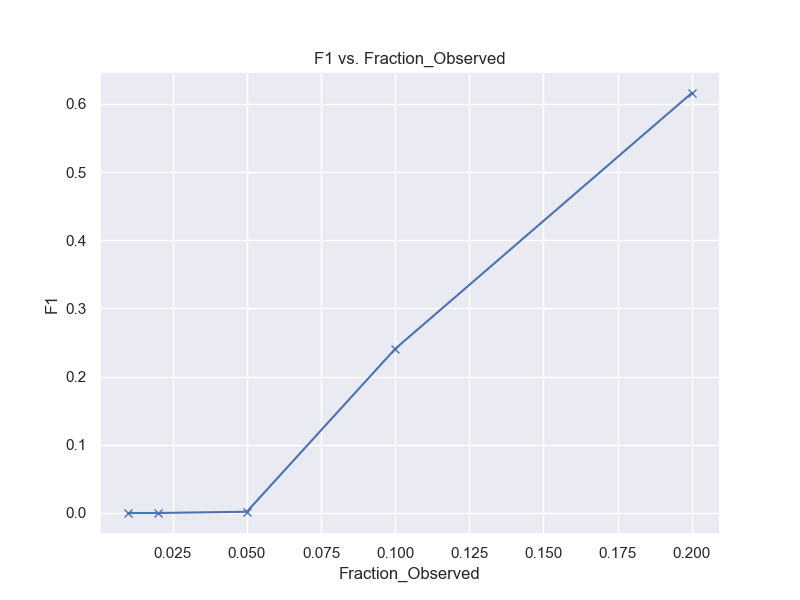

<IPython.core.display.Javascript object>

In [9]:
help(atd2020.metrics.plot)
help(atd2020.metrics.flatten)

atd2020.metrics.plot(
    atd2020.metrics.flatten(metrics_baseline),
    metric="F1",
    numeric_x=True,
    marker="x",
    legend=None,
)

We can make the same conclusions from this plot as the above metrics table. However, it is perhaps easier to see the trend that `F1` increases as `Fraction_Observed` increases.

# Plot forecast and anomaly predictions for several stations

Another way to view the baseline anomaly detector is to zoom out of 'ID', 'Weekday', and 'Hour' groups to see what the $3\sigma$ confidence intervals look like at the detector level.

Help on function plot in module atd2020.detector:

plot(df, ax=None)
    Plot the detector's forecast and predicted anomalies.
    
    Parameters
    ----------
    df : pandas.DataFrame
        Contains columns=["Timestamp", "lower_thresh", mean", upper_thresh",
        "TotalFlow", "Anomaly"]
    
    ax : matplotlib.axes.Axes, default=None
        Axes upon which to plot. If None, an axes is created.
    
    Returns
    -------
    matplotlib.axes.Axes
        Axes with detector forecast and predicted anomalies plotted.
            * x-axis Timestamp
            * y-axis TotalFlow
            * Red `x` markers for anomalies
            * Black `.` markers for normal observations
            * Blue line for mean predicted value
            * Gray region between lower/upper anomaly thresholds



<IPython.core.display.Javascript object>


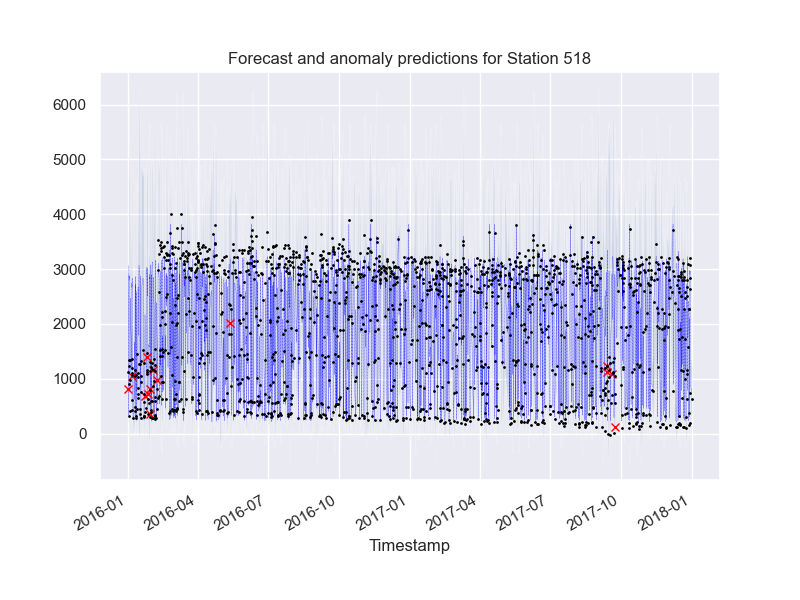

Text(0.5, 1.0, 'Forecast and anomaly predictions for Station 518')

<IPython.core.display.Javascript object>

In [13]:
help(atd2020.detector.plot)

station = 518
atd2020.detector.plot(anomalies_baseline.groupby("ID").get_group(station))
plt.title(f"Forecast and anomaly predictions for Station {station}")

Just as before, we can zoom in on the plot to see where observations lie with respect to the confidence intervals. Those outside the shaded region are anomalies. Let's look at another sensor for good measure.

<IPython.core.display.Javascript object>


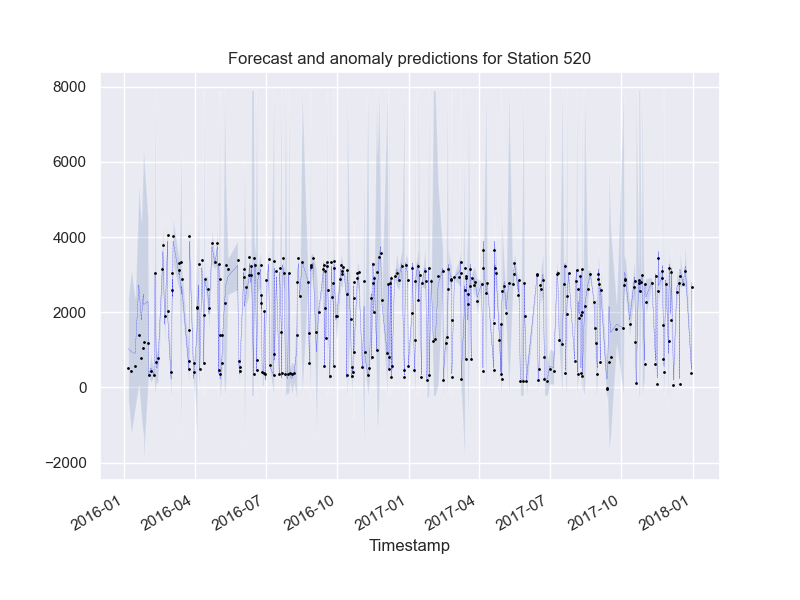

Text(0.5, 1.0, 'Forecast and anomaly predictions for Station 520')

<IPython.core.display.Javascript object>

In [12]:
station = 520
atd2020.detector.plot(anomalies_baseline.groupby("ID").get_group(station))
plt.title(f"Forecast and anomaly predictions for Station {station}")

# Can we improve performance by using different detector settings?
In the calculations above, we made anomaly predictions using $3\sigma$ confidence intervals and `('ID','Hour','Weekday')` groups, which reflects how the anomaly *truths* were defined, but is this the best performing model at low downsampling rates?

We will try varying several parameters:

* groupby - The groups of observations over which mean and stdev are computed.
* n_stds - Number of standard deviations away from the mean after which we consider an observation anomalous.
* datasets - Try running on both the detrended data and raw data

We'll iterate over many combinations of these parameter settings and compare their performance using metrics results.

## Run anomaly detection with different settings

In [ ]:
# Generate many combinations of detector settings
groupby = [
    ("ID", "Weekday", "Hour"),
    ("ID", "Hour"),
]
n_stds = [2, 3]
datasets = {"raw": data, "detrended": data_detrended}
settings = list(itertools.product(groupby, datasets.keys(), n_stds))

print("Computing anomalies using detectors with the following detector settings:")
for s in settings:
    print("\t", s)

# Detect anomalies using all setting combinations
anomalies = [
    atd2020.detector.BaselineDetector(groupby=groupby).fit_predict(
        datasets[dataset_choice], n_std=n_std
    )
    for groupby, dataset_choice, n_std in settings
]
settings_anomalies = list(zip(settings, anomalies))

# Compute metrics for all the detectors' output

In [ ]:
df_metrics = pd.concat(
    [
        atd2020.metrics.metrics(
            data, anom, groupby="Fraction_Observed", output_flat=True
        )
        for setting, anom in settings_anomalies
    ],
).set_index(pd.MultiIndex.from_tuples(settings, names=("groupby", "dataset", "n_std")))
display(df_metrics)

There are 8 variations of our anomaly detector in the table above, each with metrics computed for the "overall" downsampled data set and for the `Fraction_Observed` groups `[0.01, 0.02, 0.05, 0.10, 0.20]`, where each group contains 100 sensors not found in any other group and the fraction refers the fraction of observations kept after downsampling.

Since this table is a bit unwieldy, let's look at columns related to one metric at a time. Let's define a helper function to select the relevant columns and sort in descending order by the performance at a particicular `Fraction_Observed`.

In [ ]:
def display_metric(df, metric, at="overall"):
    cols = sorted([col for col in df.columns if col.startswith(metric)])
    display(df[cols].sort_values(by=f"{metric}@{at}", ascending=False))

Let's start with recall, the fraction of the true anomalies detected.

In the table below, we see that recall increases as `Fraction_Observed` increases for all model variations. We see that 𝜎=2 detectors recall more anomalies than 𝜎=3 detectors, but this is to be expected, as a lower 𝜎 yields tighter thresholds for what the detector considers "normal activity".

Of note, we see the ((ID, Weekday, Hour), detrended, $\sigma$=3) detector had a Recall<sub>1</sub>@0.01 score of 0, meaning the detector did not accurately predict any anomalies for the most sparsely sampled sensors.

This was the model used to define true anomalies, so it is perhaps surprising that it performed so poorly. However, because there are so few observations when `Fraction_Observed` is low, a possible explanation is that the model did not have enough data to accurately estimate the mean and standard deviations for all (ID, Weekday, Hour) groups.

In [ ]:
display_metric(df_metrics, "Recall", at="overall")

Let's now turn to precision. We find that $\sigma = 2$ detectors are less precise than $\sigma = 3$ detectors. This is expected as a corollary of our reasoning above-- being more willing to accept observations as anomalies increases the false positive rate and decreases precision.

In [ ]:
display_metric(df_metrics, "Precision", at="overall")

Because precision and recall each tell only part of the story for a classifier's performance, let's look at F<sub>1</sub> score, which is the harmonic mean of precision and recall.

Looking at F<sub>1</sub>, the best performing detector was ((ID, Hour), detrended, $\sigma$=3).

We see a few interesting trends:
* detrended outperformed raw when all other settings were equal
* $\sigma$=3 detectors outperformed $\sigma$=2 when all other settings were equal

In [ ]:
display_metric(df_metrics, "F1", at="overall")

However, we see that lowering $\sigma$ from $3$ to $2$ yielded an improvement in performance in F<sub>1</sub>@0.01 score.

In [ ]:
display_metric(df_metrics, "F1", at=0.01)

# Plot detector $F_{1}$ score vs. `Fraction_Observed`

We can plot all the detectors F<sub>1</sub> scores in a single plot.

In [ ]:
sns.set(rc={"figure.figsize": (8, 6)})
ax = atd2020.metrics.plot(
    df_metrics.loc[[("ID", "Weekday", "Hour")], :, :],
    numeric_x=True,
    metric="F1",
    marker="x",
    linestyle="dashed",
)
ax = atd2020.metrics.plot(
    df_metrics.loc[[("ID", "Hour")], :, :],
    numeric_x=True,
    metric="F1",
    marker="o",
    linestyle="solid",
    ax=ax,
)

We see that detectors using groupby=(ID, Weekday, Hour) perform worse than detectors using groupby=(ID, Hour) for small values of `Fraction_Observed`.

# Enjoy!